In [2]:
import os
from pathlib import Path
from collections import defaultdict, OrderedDict
import json
import torch
from tqdm import tqdm  
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as tvf
import gc
from io import BytesIO
from tempfile import gettempdir
import math
from timm.utils import AverageMeter
import random
import torch.nn.functional as F
from torchvision import transforms
import numpy as np


from lvae.models.registry import get_model



/home/ub/anaconda3/envs/icmil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def imcoding_evaluate_for_pkl(model: torch.nn.Module, wsi_dir: str):
    assert hasattr(model, 'compress_file')
    assert hasattr(model, 'decompress_file')

    features = defaultdict(dict)
    img_paths = sorted(list(Path(wsi_dir).glob('*.*')))

    tmp_bits_dir = Path(gettempdir())
    pbar = tqdm(img_paths, ascii=True)
    all_image_stats = defaultdict(AverageMeter)

    for impath in pbar:
        tmp_bits_path = tmp_bits_dir / f'{impath.stem}.bits'

        model.compress_file(impath, tmp_bits_path)
        num_bits = tmp_bits_path.stat().st_size * 8
        fake, feature = model.decompress_file(tmp_bits_path)
        fake = fake.squeeze(0).cpu()
        feature = feature[0] 

        fake = (fake - fake.min()) / (fake.max() - fake.min())
        fake_img = transforms.ToPILImage()(fake)

        real_img = Image.open(impath).convert("RGB")
        real_tensor = tvf.to_tensor(real_img)

        real_img = real_img.resize(fake_img.size) 

        tmp_bits_path.unlink()

        wsi_name = impath.parent.name
        x_str, y_str = impath.stem.split('_')
        x, y = int(x_str), int(y_str)
        features[wsi_name][(x, y)] = F.avg_pool2d(feature, kernel_size=4, stride=4)

        mse = (real_tensor - fake).square().mean().item()
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))
        bpp = num_bits / float(real_tensor.shape[1] * real_tensor.shape[2])
        stats = {
            'bpp':  float(bpp),
            'mse':  float(mse),
            'psnr': float(psnr)
        }

        for k, v in stats.items():
            all_image_stats[k].update(v)

        msg = ', '.join([f'{k}={v:.3f}' for k, v in stats.items()])
        pbar.set_description(f'image {impath.stem}: {msg}')

    results = {k: meter.avg for k, meter in all_image_stats.items()}
    return results, features, real_img, fake_img

In [4]:
model = 'qres34m'
lmb = 2048
dataset_path = "./c16_fig_recon_test"

In [5]:
model = get_model(model, lmb=lmb)
model_path = '../best.pt'
model.load_state_dict(torch.load(model_path)['model'], strict=True)

model.compress_mode()
model = model.to(device='cuda')
model.eval()

HierarchicalVAE(
  (encoder): BottomUpEncoder(
    (enc_blocks): ModuleList(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1-6): 6 x MyConvNeXtBlock(
        (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
        (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=384, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=384, out_features=192, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (shortcut): Identity()
        (drop_path): Identity()
      )
      (7): MyConvNeXtPatchDown(
        (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
        (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_f

In [8]:
root_dir = Path(dataset_path)
wsi_dirs = sorted([p for p in root_dir.iterdir() if p.is_dir()])

for wsi_dir in tqdm(wsi_dirs, desc="Processing WSIs"):
    result, _, fake_image, real_image = imcoding_evaluate_for_pkl(model, wsi_dir)

image 15424_19072: bpp=3.531, mse=0.000, psnr=43.946: 100%|##########| 1/1 [00:00<00:00,  2.08it/s]
Processing WSIs: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


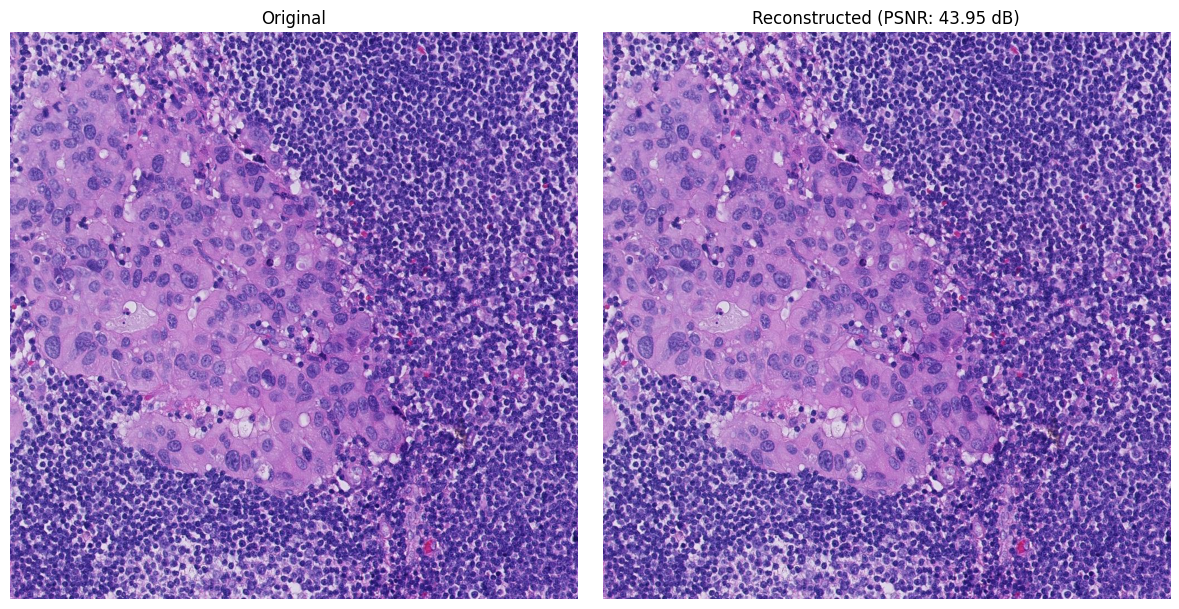

In [9]:
psnr = result['psnr']
original_np = real_image if isinstance(real_image, np.ndarray) else np.array(real_image)
reconstructed_np = fake_image if isinstance(fake_image, np.ndarray) else np.array(fake_image)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_np)
axs[0].set_title('Original')
axs[1].imshow(reconstructed_np)
axs[1].set_title(f'Reconstructed (PSNR: {psnr:.2f} dB)')
for ax in axs:
    ax.axis('off')
plt.tight_layout()